# Initial Initializations

### Hexagon Grid Classes

In [1]:
class Coordinates:

  # Taking in Axial Coordinate Q R
  def __init__(self, q : int, r : int):
    # Using axial coordinates system in https://www.redblobgames.com/grids/hexagons

    # Vertical axis q
    self.q = q

    # Skewed axis r
    self.r = r

  # In an axial coordinates system, S can be computed on the fly
  def __get_s(self):
      return -self.q - self.r

  # for col index in array coordinate space (convert axial coordinate to its storage in the array)
  def __get_x(self):
    return self.q

  # for row index in array coordinate space (convert axial coordinate to its storage in the array)
  def __get_y(self):
    return self.r + (self.q // 2)

  def __get_axial(self):
    return (self.q, self.r)

  s = property(__get_s) # Axial Coordinate S
  axial = property(__get_axial)

  x = property(__get_x)
  y = property(__get_y)

  def print_axial_coordinate(self):
    return "Axial [ Q:" + str(self.q) + ", R:" + str(self.r) + " ] "

  def print_array_coordinate(self):
    return "Array [ X:" + str(self.x) + ", Y:" + str(self.y) + " ]"

  def __str__(self):
    msg = self.print_axial_coordinate() + self.print_array_coordinate()

    return msg

  def __repr__(self):
    return f"({self.q}, {self.r})"

In [2]:
class Room:
  def __get_has_trash(self):
    return self.trash_weight > 0 and self.trash_volume > 0

  has_trash = property(__get_has_trash)

  def __init__(self, coords : Coordinates, trash_weight : int = 0, trash_volume : int = 0, is_disposal_room : bool = False):
    assert trash_weight >= 0, "Weight cannot be negative"
    assert trash_volume >= 0, "Volume cannot be negative"

    self.coords = coords
    self.trash_weight = trash_weight
    self.trash_volume = trash_volume
    self.is_disposal_room = is_disposal_room

    if self.has_trash :
      assert not self.is_disposal_room, "Disposal rooms cannot have trash"

  def setup_as_rubbish_room(self, trash_weight : int = 0, trash_volume : int = 0):
    assert trash_weight >= 0, "Weight cannot be negative"
    assert trash_volume >= 0, "Volume cannot be negative"
    self.trash_weight = trash_weight
    self.trash_volume = trash_volume

    if self.has_trash:
      assert not self.is_disposal_room, "Disposal rooms cannot have trash"

  def setup_as_disposal_room(self):
    self.is_disposal_room = True

    if self.has_trash:
      assert not self.is_disposal_room, "Disposal rooms cannot have trash"

  def __str__(self):
    msg = str(self.coords) + " -> "
    msg += "trash_weight : " + str(self.trash_weight) + ", "
    msg += "trash_volume : " + str(self.trash_volume) + ", "
    msg += "is_disposal : " + str(self.is_disposal_room)
    return msg

  def __repr__(self):
    return str(self)

In [3]:
class HexGrid:
  directions = [
      Coordinates(0, -1),
      Coordinates(1, -1),
      Coordinates(1, 0),
      Coordinates(0, 1),
      Coordinates(-1, 1),
      Coordinates(-1, 0),
  ]

  def __init__(self, **kwargs):
    width, height = kwargs.get("rect_size", (-1, -1)) # hex w/h is used for rect hex-grid map, not used for hexagonal hex-grid map

    use_odd_q_vertical_layout = kwargs.get("is_odd_q", False) # if the odd columns are shifted up
    self.odd_q_offset = 0 if use_odd_q_vertical_layout else 1

    self.rooms = [[Room(Coordinates(col, row - ((col + self.odd_q_offset) // 2))) for row in range(height)] for col in range (width)] # create a rect grid. Each array represents a column in self.rooms


  def get_room_at(self, coords: Coordinates):
    x = coords.x
    y = coords.y + ((coords.x % 2) * self.odd_q_offset)

    if y < 0 or y > len(self.rooms[x]):
      print("Cannot get room at : " + str(x) + " " + str(y))
      return None

    if x < 0 or x > len(self.rooms):
      print("Cannot get room at : " + str(x) + " " + str(y))
      return None

    return self.rooms[x][y]

  def print_dimensions(self):
    print("Printing grid dimensions.\nTotal columns" + str(len(self.rooms)))
    for idx, col in enumerate(self.rooms):
      print("Col " + str(idx) + ": " + str(len(col)))

**Visualization Code**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colours

def room_fill_col(room: Room):
  fill_col = "#ffffff"

  if room.is_disposal_room:
    fill_col = "#fff0c8"
  elif room.has_trash:
    if room.trash_weight == 5:
      fill_col = "#dd9933"
    elif room.trash_weight == 10:
      fill_col = "#14bebe"
    elif room.trash_weight == 20:
      fill_col = "#666999"
    elif room.trash_weight == 30:
      fill_col = "#b478cd"

  return fill_col

class HexGridVisualiser:
  fig_width = 5
  half_hex_offset = np.sqrt(3)/2 # cos(60°)

  @staticmethod
  def clamp(value, smallest, largest):
    return max(smallest, min(largest, value))

  def __init__(self, grid_map: HexGrid, border_col="grey", room_col_func = None):
    self.grid_map = grid_map
    self.border_col = border_col
    self.room_col_func = room_col_func
    self.figure, self.axes = plt.subplots()

  def plot_hex_at(self, room : Room, given_col = None):
    coords = room.coords
    x = coords.x
    y = coords.y

    x_vals = [self.half_hex_offset / 2, self.half_hex_offset * 3 / 2, self.half_hex_offset * 2, self.half_hex_offset * 3 / 2, self.half_hex_offset / 2, 0]
    x_vals.append(x_vals[0])
    x_vals += x * self.half_hex_offset * 3 / 2

    y = -y
    y_vals = [0, 0, self.half_hex_offset, self.half_hex_offset * 2, self.half_hex_offset * 2, self.half_hex_offset, ]
    y_vals.append(y_vals[0])
    y_vals += (y + ((x + 1) % 2) / 2) * self.half_hex_offset * 2

    self.axes.plot(x_vals, y_vals, color=self.border_col)

    if given_col is None:
      fill_col = self.room_col_func(room) if self.room_col_func is not None else "#ffffff"
    else:
      fill_col = given_col

    self.axes.fill(x_vals, y_vals, color=fill_col)

    text_pos_x = (x + 0.35) * self.half_hex_offset * 3 / 2
    text_pos_y = (y + ((x + 1) % 2) / 2 + 0.35) * self.half_hex_offset * 2

    coords_str = str(coords.q) + ', ' + str(coords.r)

    if room.has_trash:
      self.axes.text(text_pos_x, text_pos_y, coords_str + "\n " + str(room.trash_volume) +"m", fontsize = 8)
    else:
      self.axes.text(text_pos_x, text_pos_y, coords_str, fontsize = 10)

  def visualise(self):
    self.axes.clear() # Make sure previous axes set are cleared first

    self.axes.set_title("Current Hex Grid Map")

    flattened_rooms = [room for col in self.grid_map.rooms for room in col]
    for room in flattened_rooms:
      self.plot_hex_at(room)

    # Show plot after setting its axes
    plt.show()

  def visualiseAnim(self, e_room):
    flattened_rooms = [room for col in self.grid_map.rooms for room in col]
    for room in flattened_rooms:
      if (room.coords.axial == e_room.coords.axial):
        self.plot_hex_at(room, given_col="#ff0000")
      else:
        self.plot_hex_at(room)



In [5]:
class RubbishBin:
  def __init__(self, max_volume : int = 5, max_weight : int = 40):
    assert max_volume > 0, "Max Volume must be a postive integer"
    assert max_weight > 0, "Max Weight must be a postive integer"

    self.max_volume = max_volume
    self.max_weight = max_weight

    self.current_volume = 0
    self.current_weight = 0

  def add_weight(self, weight: int):
    self.current_weight += weight
    assert self.current_weight <= self.max_weight, f"Current weight can't be bigger than Max Weight. Current:{self.current_weight}"

  def add_volume(self, volume: int):
    self.current_volume += volume
    assert self.current_volume <= self.max_volume, f"Current volume can't be bigger than Max Volume. Current:{self.current_volume}"

  def dispose_trash(self):
    self.current_volume = 0
    self.current_weight = 0

  def check_fit(self, volume: int, weight: int):
    if (self.current_volume + volume) <= self.max_volume:
      if (self.current_weight + weight) <= self.max_weight:
        return True

    return False

  def is_empty(self):
    return (self.current_weight == 0) and (self.current_volume == 0)

### Algorithms Required

In [6]:
class PathState:
  def __get_cheapest_cost(self):
    return self.g_cost + self.h_cost

  cheapest_cost = property(__get_cheapest_cost)

  def __init__(self, explored_rooms: list[Room], rubbish_bin: RubbishBin):
    self.explored_rooms = explored_rooms

    # Done to create different objects in memory for RubbishBin instantiation
    self.rubbish_bin = RubbishBin(rubbish_bin.max_volume, rubbish_bin.max_weight)
    self.rubbish_bin.current_weight = rubbish_bin.current_weight
    self.rubbish_bin.current_volume = rubbish_bin.current_volume

    # Current G_Cost and H_Cost
    self.g_cost = 0
    self.h_cost = 0

In [7]:
class StateMachine:

  def __init__(self, hex_grid : HexGrid, rubbish_bin : RubbishBin, startRoomCoords:Coordinates):

    # The Hexagon grid we will be utilizing
    self.hex_grid = hex_grid

    # The initial rubbish bin
    self.rubbish_bin = rubbish_bin

    # Add X room if X is a disposal room via  X element in col inner array taken from hex_grid.rooms array
    self.disposal_rooms = [x for col in hex_grid.rooms for x in col if x.is_disposal_room]
    print("Disposal Rooms")
    print(*self.disposal_rooms, sep="\n")

     # Add X room if X has trash via X element in col inner array taken from hex_grid.rooms array
    self.rooms_with_rubbish = [x for col in hex_grid.rooms for x in col if x.has_trash]
    print("\nRooms with Rubbish")
    print(*self.rooms_with_rubbish, sep="\n")

    # Starting Path object with the starting node coordinates and starting rubbisn bin
    self.start_state = PathState([ self.hex_grid.get_room_at(startRoomCoords) ], self.rubbish_bin)

  def find_unexplored_rooms_in_path(self, path: PathState):
    # Append to array if room is not found in the path's explored room array
    return [room for room in self.rooms_with_rubbish if room not in path.explored_rooms]

  def expand_child_state(self, path: PathState, new_room: Room):
    # Returns a new PathState object by appending the new room to the current path given and perform all the necessary functions to make it valid

    new_explored_rooms = path.explored_rooms.copy() # wont reference the previous explored_rooms array
    new_explored_rooms.append(new_room)
    new_path = PathState(new_explored_rooms, path.rubbish_bin)
    new_rubbish_bin = new_path.rubbish_bin

    if new_room.has_trash:
      new_rubbish_bin.add_weight(new_room.trash_weight)
      new_rubbish_bin.add_volume(new_room.trash_volume)

    else:
      # if the new room is detected not to have trash, then it is a disposal room so we straight away dispose trash
      new_rubbish_bin.dispose_trash()

    return new_path

  def expand_all_children_states(self, path: PathState):
    unexplored_rooms = self.find_unexplored_rooms_in_path(path)
    child_paths = []

    for room in unexplored_rooms:
      if path.rubbish_bin.check_fit(room.trash_volume, room.trash_weight):
        new_path = self.expand_child_state(path, room)

        child_paths.append(new_path)

    # No new path can be explored due to no room fitting the rubbish bin, so create paths for all disposal room possible
    if len(child_paths) < 1:
      for disposal_room in self.disposal_rooms:
        new_path = self.expand_child_state(path, disposal_room)

        child_paths.append(new_path)

    return child_paths

In [8]:
def dist_function(coords1 : Coordinates, coords2 : Coordinates):
  dist_q = abs(coords1.q - coords2.q)
  dist_r = abs(coords1.r - coords2.r)
  dist_s = abs(coords1.s - coords2.s)

  return (dist_q + dist_r + dist_s) / 2


class GCostModel:
  def __init__(self, calc_distance, start_room: Room, distance_per_unit : int = 1):
    self.distance_per_unit = distance_per_unit
    self.calc_distance = calc_distance
    self.start_room = start_room

  def apply(self, path: PathState):
    total_distance = 0
    previous_room = self.start_room
    for room in path.explored_rooms:
      distance = self.calc_distance(previous_room.coords, room.coords)
      total_distance += distance
      previous_room = room

    return total_distance


class HCostModel:
  def __init__(self, state_machine: StateMachine):
    self.state_machine = state_machine
    pass

  def apply(self, path: PathState):
    # add remaining weight and volume capacity
    current_coords = path.explored_rooms[-1].coords
    disposal_rooms = self.state_machine.disposal_rooms
    min_distance = min([dist_function(current_coords, x.coords) for x in disposal_rooms])
    avg_distance = sum([dist_function(current_coords, x.coords) for x in disposal_rooms]) / len(disposal_rooms)

    unexplored_rooms = self.state_machine.find_unexplored_rooms_in_path(path)
    total_weight = sum(x.trash_weight for x in unexplored_rooms) # - rubbish_bin.current_weight
    total_volume = sum(x.trash_volume for x in unexplored_rooms) # - rubbish_bin.current_volume
    min_trips = max(total_weight / path.rubbish_bin.max_weight, total_volume / path.rubbish_bin.max_volume)

    if min_trips == 0:
      return min_distance

    return avg_distance * min_trips + min_distance


# Problem Statement

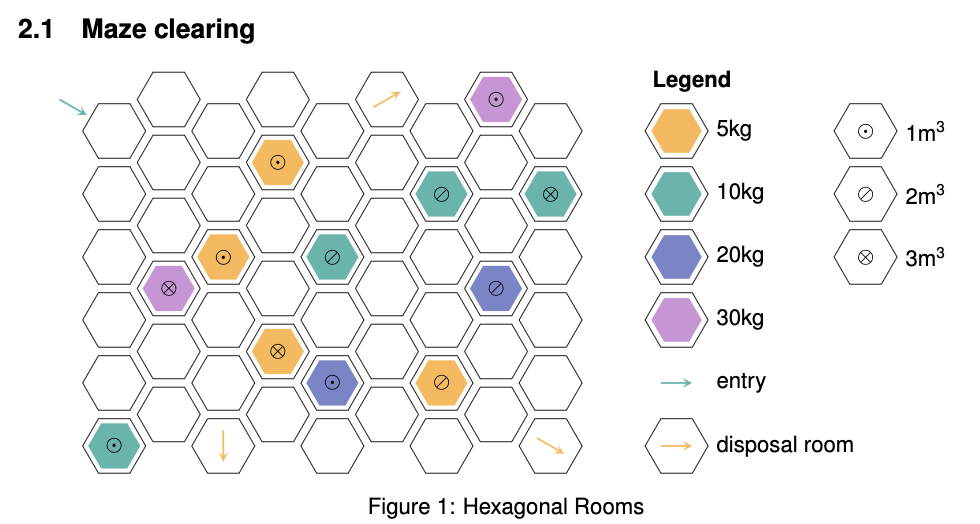

### Creation of Maze Grid Map

JSON loaded


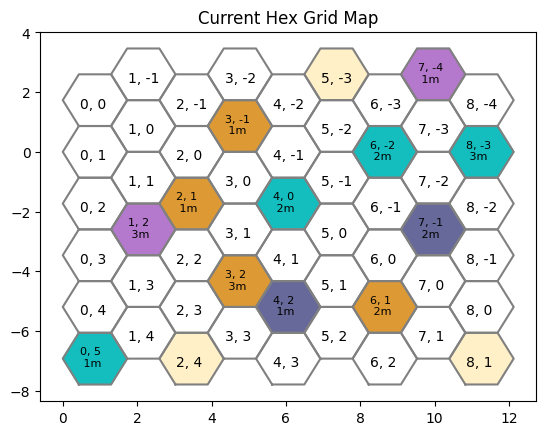

In [9]:
import json

try:
  # Load JSON file
  maze_grid_params = json.load(open("HexGrid.json"))
  print("JSON loaded")

except FileNotFoundError:
  # How the JSON file should look like
  maze_grid_params = {
    "size": {"width":9, "height":6},
    "rubbish bin":{"weight":40, "volume":5},
    "start room":{"axialQ":0,"axialR":0},
    "Rubbish Rooms":[
        {"type":"rubbish", "axialQ":0,"axialR":5,"weight":10,"volume":1}, {"type":"rubbish", "axialQ":1,"axialR":2,"weight":30,"volume":3},
        {"type":"rubbish", "axialQ":2,"axialR":1,"weight":5,"volume":1},{"type":"rubbish", "axialQ":3,"axialR":-1,"weight":5,"volume":1},
        {"type":"rubbish", "axialQ":3,"axialR":2,"weight":5,"volume":3},  {"type":"rubbish", "axialQ":4,"axialR":0,"weight":10,"volume":2},
        {"type":"rubbish", "axialQ":4,"axialR":2, "weight":20,"volume":1},{"type":"rubbish", "axialQ":6,"axialR":-2, "weight":10,"volume":2},
        {"type":"rubbish", "axialQ":6,"axialR":1, "weight":5,"volume":2}, {"type":"rubbish", "axialQ":7,"axialR":-4, "weight":30,"volume":1},
        {"type":"rubbish", "axialQ":7,"axialR":-1, "weight":20,"volume":2},{"type":"rubbish", "axialQ":8,"axialR":-3, "weight":10,"volume":3}
    ],
    "Disposal Rooms":[
        {"type":"disposal", "axialQ":2,"axialR":4 },
        {"type":"disposal", "axialQ":5,"axialR":-3 }  ,
        {"type":"disposal", "axialQ":8,"axialR":1 }
    ]
  }

# Initialize maze_grip_map size (W, H)
maze_grid_map = HexGrid(rect_size = (maze_grid_params["size"]["width"], maze_grid_params["size"]["height"]))

# Initialize the special rooms of the grid and give the rooms their appropriate attributes
for rubbish_room in maze_grid_params['Rubbish Rooms']:
  maze_grid_map.get_room_at(Coordinates(rubbish_room["axialQ"], rubbish_room["axialR"])).setup_as_rubbish_room(rubbish_room["weight"], rubbish_room["volume"])

for rubbish_room in maze_grid_params['Disposal Rooms']:
  maze_grid_map.get_room_at(Coordinates(rubbish_room["axialQ"], rubbish_room["axialR"])).setup_as_disposal_room()

# Visualize the HexGrid map made
visual = HexGridVisualiser(maze_grid_map, room_col_func=room_fill_col)
visual.visualise()
plt.show()

### Main algorithm definition and run

In [10]:
import bisect

class AStarAlgorithm:
  def __init__(self, state_machine, g_cost_model, h_cost_model, goal_condition, time_out_iterations = 1500000, print_progress_interval = 1000):
    self.state_machine = state_machine
    self.g_cost_model = g_cost_model
    self.h_cost_model = h_cost_model
    self.goal_condition = goal_condition
    self.time_out_iterations = time_out_iterations
    self.print_progress_interval = print_progress_interval

  def apply(self):
    goal_found = False
    iterations_ran = 0
    chosen_path = None

    print("\n\n ======= Running the AStar Algorithm ======= \n")

    frontier = [self.state_machine.start_state]
    while not goal_found:
      iterations_ran += 1

      current_path = frontier[0]
      frontier.pop(0)

      # Print out info if the iteration interval is reached
      if iterations_ran % self.print_progress_interval == 0:
        print("Iteration ", iterations_ran)
        print([room.coords for room in current_path.explored_rooms])
        print("g_cost -> ", current_path.g_cost)
        print("h_cost -> ", current_path.h_cost)
        print("cheapest_cost -> ", current_path.cheapest_cost)
        print("rubbish_bin -> weight: ", current_path.rubbish_bin.current_weight, "volume: ", current_path.rubbish_bin.current_volume)
        print("size of frontier -> ", len(frontier))
        print("")

      # Based on the given goal_condition function pass, check if condition has been reached
      if self.goal_condition(current_path):
        goal_found = True
        chosen_path = current_path

        break

      children = self.state_machine.expand_all_children_states(current_path)
      for child in children:
        child.g_cost = self.g_cost_model.apply(child)
        child.h_cost = self.h_cost_model.apply(child)

        # Automnatically insert the child into the right position sorted from lowest to highest based on the key of cheapest_cost
        bisect.insort(frontier, child, key=lambda x: x.cheapest_cost)

      if iterations_ran >= self.time_out_iterations:
        print("The algorithm is taking too long to run, terimating")
        print("\n ======= End of Algorithm =======\n")
        goal_found = True

    print("\n ======= End of Algorithm =======\n")
    return chosen_path

start_room_coords = Coordinates(maze_grid_params["start room"]["axialQ"], maze_grid_params["start room"]["axialR"])
start_room = maze_grid_map.get_room_at(start_room_coords)

rubbish_bin = RubbishBin(maze_grid_params["rubbish bin"]["volume"], maze_grid_params["rubbish bin"]["weight"]) # volume, weight

global_state_machine = StateMachine(maze_grid_map, rubbish_bin, start_room_coords)
g_cost_model = GCostModel(dist_function, start_room)
h_cost_model = HCostModel(global_state_machine)

def check_goal(path: PathState):
  # If unexplored rooms for this path is empty and this path has no more rubbish in rubbish bin, goal has been achieved
  return not global_state_machine.find_unexplored_rooms_in_path(path) and path.rubbish_bin.is_empty()

a_star = AStarAlgorithm(global_state_machine, g_cost_model, h_cost_model, check_goal)
path = a_star.apply()

if not path:
  print("Solution not found!")
else:
  print("Path Cost: ", path.cheapest_cost)
  print("Path Rubbish Weight: ", path.rubbish_bin.current_weight)
  print("Path Rubbish Volume: ",path.rubbish_bin.current_volume)
  print("\nPath\n=====")
  msg = ""
  tab = "    "
  for room in path.explored_rooms:
    if room.has_trash:
      if msg == "":
        msg += tab + "Removing rubbish:\n"
      msg += tab + tab + str(room.coords) + "\n"
    elif room.is_disposal_room:
      print(msg + "\n")
      print(tab + "Moving to disposal room : " + str(room.coords) + "\n")
      msg = ""
    else :
      print(tab + "At room : " + str(room.coords) + "\n")

Disposal Rooms
Axial [ Q:2, R:4 ] Array [ X:2, Y:5 ] -> trash_weight : 0, trash_volume : 0, is_disposal : True
Axial [ Q:5, R:-3 ] Array [ X:5, Y:-1 ] -> trash_weight : 0, trash_volume : 0, is_disposal : True
Axial [ Q:8, R:1 ] Array [ X:8, Y:5 ] -> trash_weight : 0, trash_volume : 0, is_disposal : True

Rooms with Rubbish
Axial [ Q:0, R:5 ] Array [ X:0, Y:5 ] -> trash_weight : 10, trash_volume : 1, is_disposal : False
Axial [ Q:1, R:2 ] Array [ X:1, Y:2 ] -> trash_weight : 30, trash_volume : 3, is_disposal : False
Axial [ Q:2, R:1 ] Array [ X:2, Y:2 ] -> trash_weight : 5, trash_volume : 1, is_disposal : False
Axial [ Q:3, R:-1 ] Array [ X:3, Y:0 ] -> trash_weight : 5, trash_volume : 1, is_disposal : False
Axial [ Q:3, R:2 ] Array [ X:3, Y:3 ] -> trash_weight : 5, trash_volume : 3, is_disposal : False
Axial [ Q:4, R:0 ] Array [ X:4, Y:2 ] -> trash_weight : 10, trash_volume : 2, is_disposal : False
Axial [ Q:4, R:2 ] Array [ X:4, Y:4 ] -> trash_weight : 20, trash_volume : 1, is_disposal

KeyboardInterrupt: 

**Solution for problem statement**

* Path Final Cost:  38
* Path Final Rubbish Weight:  0
* Path Final Rubbish Volume:  0 <br><br>

Path Solution
=====

    At room : Axial [ Q:0, R:0 ] Array [ X:0, Y:0 ]

    Removing rubbish:
        Axial [ Q:1, R:2 ] Array [ X:1, Y:2 ]
        Axial [ Q:2, R:1 ] Array [ X:2, Y:2 ]
        Axial [ Q:3, R:-1 ] Array [ X:3, Y:0 ]


    Moving to disposal room : Axial [ Q:5, R:-3 ] Array [ X:5, Y:-1 ]

    Removing rubbish:
        Axial [ Q:6, R:-2 ] Array [ X:6, Y:1 ]
        Axial [ Q:7, R:-4 ] Array [ X:7, Y:-1 ]


    Moving to disposal room : Axial [ Q:5, R:-3 ] Array [ X:5, Y:-1 ]

    Removing rubbish:
        Axial [ Q:8, R:-3 ] Array [ X:8, Y:1 ]
        Axial [ Q:7, R:-1 ] Array [ X:7, Y:2 ]


    Moving to disposal room : Axial [ Q:8, R:1 ] Array [ X:8, Y:5 ]

    Removing rubbish:
        Axial [ Q:6, R:1 ] Array [ X:6, Y:4 ]
        Axial [ Q:4, R:0 ] Array [ X:4, Y:2 ]
        Axial [ Q:4, R:2 ] Array [ X:4, Y:4 ]


    Moving to disposal room : Axial [ Q:2, R:4 ] Array [ X:2, Y:5 ]

    Removing rubbish:
        Axial [ Q:3, R:2 ] Array [ X:3, Y:3 ]
        Axial [ Q:0, R:5 ] Array [ X:0, Y:5 ]


    Moving to disposal room : Axial [ Q:2, R:4 ] Array [ X:2, Y:5 ]

In [ ]:
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  # resolution
plt.ioff() # turn interative mode off

animVisualizer = HexGridVisualiser(maze_grid_map, room_col_func=room_fill_col)
path_cost_acum = 0
weight_acum = 0
volume_acum = 0

def animate(i):
  global path_cost_acum
  global weight_acum
  global volume_acum

  e_room = path.explored_rooms[i]

  if i > 0:
    path_cost_acum += dist_function(path.explored_rooms[i - 1].coords, e_room.coords)

  if e_room.has_trash:
    volume_acum += e_room.trash_volume
    weight_acum += e_room.trash_weight
  else:
    volume_acum = 0
    weight_acum = 0

  animVisualizer.axes.clear() # clear axes value
  animVisualizer.visualiseAnim(e_room) # redraw axes values
  animVisualizer.axes.set_title(f"Step {i+1} | Current Hex: {e_room.coords.axial} | Path Cost: {path_cost_acum} | Weight: {weight_acum} | Volume {volume_acum}")

FuncAnimation(animVisualizer.figure, animate, interval = 800, frames=len(path.explored_rooms))

In [ ]:
plt.close()